# **LIMPIEZA DE DATOS**

In [9]:
import pandas as pd
import numpy as np
import string
import csv
import re

In [12]:
# Importamos el archivo csv que contiene los datos en bruto posterior a su extracción
df = pd.read_csv('rawDataset2.csv', encoding = "utf-8")

In [13]:
# Elimina los valores duplicados, siendo más específicos eliminar por ID ya que es un valor único para cada registro
df = df.drop_duplicates(df.columns[~df.columns.isin(['id'])], keep='first')
print(df.shape)

(19640, 25)


In [14]:
# Limpieza de datos
# Definimos una función que procese el texto para la respectiva limpieza
def clean_text(text):
  text = re.sub(r'^RT[\s]+', '', text) # Elimina la palabra RT que significa Retweet
  text = text.rstrip('\n')  # Elimina saltos de linea
  text = re.sub(r'https:?\/\/.*[\r\n]*', '', text) # Elimina los enlaces web
  text = re.sub(r'#', '', text) # Elimina el símbolo hashtag
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Elimina las menciones producto de la respuesta a algun comentario
  text = ' '.join(re.findall(r'\w+', text))
  text = re.sub(r'\s+', ' ', text, flags=re.I)
  text = str(text).rstrip().lstrip()
  return text
 
# Aplica la función a una nueva columna
df['content_clean'] = df['content'].apply(lambda x: clean_text(x))

In [15]:
# Añadimos dos nuevas columnas que contienen el número de caracteres y número de palabras dentro del tweet
df['length_tweet'] = df['content_clean'].apply(lambda x:len(x)) 
df['number_words'] = df['content_clean'].apply(lambda x:len(x.split(' ')))

In [16]:
# Eliminamos los tweets con una longitud de caracteres menor a 3
df = df[df['length_tweet'] > 2]
df.shape

(18731, 28)

In [17]:
# Solamente obtenemos los tweets dentro de un rango de fechas es decir un año atrás, que es la fecha que se determinó para el análisis
mask = (df['date'] > '2020-11-01') & (df['date'] <= '2021-10-31')
df=df.loc[mask]
df.shape

(17392, 28)

In [18]:
# Filtramos solamente los tweets que esten en idioma español
df = df[df['language']=='es']
print(df.shape)

(16633, 28)


In [19]:
# Filtramos solo a los tweets que esten dentro del territorio de Bolivia
df = df[df['place_country'].str.contains('Bolivia', na=True)]
print(df.shape)

(16440, 28)


In [20]:
# df.to_csv('cleanedDataset2.csv', index=False)

# **EXPLORACIÓN DE DATOS Y VARIABLES**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [23]:
# Obtenemos la cantidad de datos como filas y columnas
df.shape

(16440, 28)

In [24]:
# Una primera observación de los datos
df.head()

,id,date,user_id,user_username,user_displayname,user_created,user_followers_count,user_location,coordinates_latitude,coordinates_longitude,place_name,place_country,place_country_code,language,conversation_id,content,url,reply_count,retweeted_tweet,retweet_count,like_count,hashtags,cashtags,media,source,content_clean,length_tweet,number_words
0,1453125235549614081,2021-10-26 22:23:48+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614081,"El 25/10, https://t.co/K0ob54N9yA informó 40.0...",https://twitter.com/JRVilar/status/14531252355...,1,NaN,0,0,NaN,NaN,NaN,Twitter Web App,El 25 10 Ratio x 100 hab total 62 1 En 270 día...,171,36
1,1453125237290283017,2021-10-26 22:23:48+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614081,Inoculados ayer pauta completa (2ª dosis o uni...,https://twitter.com/JRVilar/status/14531252372...,1,NaN,0,0,NaN,NaN,NaN,Twitter Web App,Inoculados ayer pauta completa 2ª dosis o unid...,243,39
2,1453125238959529992,2021-10-26 22:23:49+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614081,Dosis llegadas hasta ayer: 15.076.036 dosis (S...,https://twitter.com/JRVilar/status/14531252389...,1,NaN,0,0,NaN,NaN,NaN,Twitter Web App,Dosis llegadas hasta ayer 15 076 036 dosis Spu...,262,44
3,1453125240771465227,2021-10-26 22:23:49+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614081,Faltantes de inmunizar con pauta completa para...,https://twitter.com/JRVilar/status/14531252407...,0,NaN,0,0,NaN,NaN,NaN,Twitter Web App,Faltantes de inmunizar con pauta completa para...,268,49
4,1453061704103903235,2021-10-26 18:11:21+00:00,1391775741357006849,dexabot,Dexanfetamina,2021-05-10 15:23:12+00:00,1676,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453061704103903235,Me vacuné con la segunda de Sputnik y ya sient...,https://twitter.com/dexabot/status/14530617041...,2,NaN,3,38,NaN,NaN,NaN,TweetDeck,Me vacuné con la segunda de Sputnik y ya sient...,132,26


In [26]:
# Obtenemos la informacion del dataset en sus columnas, cantidad de datos y tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16440 entries, 0 to 19639
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     16440 non-null  int64  
 1   date                   16440 non-null  object 
 2   user_id                16440 non-null  int64  
 3   user_username          16440 non-null  object 
 4   user_displayname       16440 non-null  object 
 5   user_created           16440 non-null  object 
 6   user_followers_count   16440 non-null  int64  
 7   user_location          9555 non-null   object 
 8   coordinates_latitude   671 non-null    float64
 9   coordinates_longitude  671 non-null    float64
 10  place_name             671 non-null    object 
 11  place_country          671 non-null    object 
 12  place_country_code     671 non-null    object 
 13  language               16440 non-null  object 
 14  conversation_id        16440 non-null  int64  
 15  co

In [27]:
# Obtenemos un resumen estadístico para los valores numéricos
df.describe()

,id,user_id,user_followers_count,coordinates_latitude,coordinates_longitude,conversation_id,reply_count,retweeted_tweet,retweet_count,like_count,length_tweet,number_words
count,1.644000e+04,1.644000e+04,1.644000e+04,671.000000,671.000000,1.644000e+04,16440.000000,0.0,16440.000000,16440.000000,16440.000000,16440.000000
mean,1.402066e+18,5.158470e+17,2.222740e+04,-22.852893,-69.585484,1.399337e+18,1.711496,NaN,3.756752,14.068248,115.767092,20.671533
std,3.877944e+16,5.807468e+17,3.049765e+05,0.477730,0.565614,4.514603e+16,27.254002,NaN,89.429827,307.126806,80.451990,14.298467
min,1.323147e+18,6.234830e+05,0.000000e+00,-22.897682,-69.640762,1.229547e+18,0.000000,NaN,0.000000,0.000000,3.000000,1.000000
25%,1.356653e+18,3.166295e+08,5.400000e+01,-22.897682,-69.640762,1.356600e+18,0.000000,NaN,0.000000,0.000000,47.000000,9.000000
50%,1.415022e+18,3.093089e+09,3.080000e+02,-22.897682,-69.640762,1.414979e+18,0.000000,NaN,0.000000,1.000000,96.000000,17.000000
75%,1.429522e+18,1.188528e+18,1.423000e+03,-22.897682,-69.640762,1.429520e+18,1.000000,NaN,0.000000,2.000000,177.000000,31.000000
max,1.454597e+18,1.453129e+18,2.039414e+07,-16.498501,-63.179470,1.454597e+18,2336.000000,NaN,8865.000000,32600.000000,280.000000,61.000000


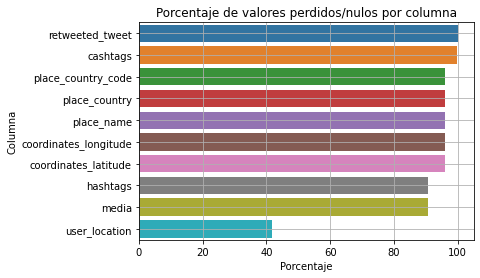

In [29]:
# Obtenemos la distribución de porcentajes de los valores perdidos o nulos
df2 = df.copy()
df2.loc[df2['hashtags'] == '[]', 'hashtags'] = np.nan
missed = pd.DataFrame()
missed['column'] = df2.columns
missed['percent'] = [round(100* df2[col].isnull().sum() / len(df2), 2) for col in df2.columns]
missed = missed.sort_values('percent', ascending=False)
missed = missed[missed['percent']>0]
fig = sns.barplot(
    x=missed['percent'], 
    y=missed["column"], 
    orientation='horizontal')
plt.title("Porcentaje de valores perdidos/nulos por columna")
plt.xlabel("Porcentaje")
plt.ylabel("Columna")
plt.grid()
plt.show()

In [30]:
# Obtenemos la información de ubicación dentro del territorio Boliviano de los tweets
def check_location(x):
    if 'santacruz' in str(x).lower() or 'sta cruz' in str(x).lower() or 'santa cruz' in str(x).lower() or 'scz' in str(x).lower() or 'montero' in str(x).lower():
        return 'Santa Cruz'
    if 'la paz' in str(x).lower() or 'lapaz' in str(x).lower() or 'lpz' in str(x).lower() or 'el alto' in str(x).lower() or 'elalto' in str(x).lower():
        return 'La Paz'
    if 'cochabamba' in str(x).lower() or 'cbba' in str(x).lower() or 'cba' in str(x).lower() or 'cocha' in str(x).lower() or 'llajta' in str(x).lower() or 'tunari' in str(x).lower():
        return 'Cochabamba'
    if 'tarija' in str(x).lower() or 'tja' in str(x).lower() or 'villa montes' in str(x).lower() or 'yacuiba' in str(x).lower():
        return 'Tarija'
    if 'chuquisaca' in str(x).lower() or 'sucre' in str(x).lower() or 'chq' in str(x).lower():
        return 'Chuquisaca'
    if 'oruro' in str(x).lower() or 'oru' in str(x).lower():
        return 'Oruro'
    if 'potosi' in str(x).lower() or 'potosí' in str(x).lower() or 'pts' in str(x).lower():
        return 'Potosí'
    if 'beni' in str(x).lower() or 'ben' in str(x).lower() or 'rurrenabaque' in str(x).lower() or 'trinidad' in str(x).lower() or 'riberalta' in str(x).lower():
        return 'Beni'
    if 'pando' in str(x).lower() or 'pnd' in str(x).lower() or 'cobija' in str(x).lower():
        return 'Pando'

df['location'] = np.nan
df['location'] = df['user_location'].apply(lambda x: check_location(x))

In [31]:
# De los valores restante obtenemos los que aún pertenezcan dentro Bolivia en general
df_location = df[df['location'].isna()]
for i in df_location.index: 
  if 'bolivia' in str(df_location['user_location'][i]).lower() or 'bolivia' in str(df_location['place_country'][i]).lower():
    df['location'][i] = 'Bolivia'

df['location'].value_counts()

Bolivia       3023
La Paz         833
Santa Cruz     543
Cochabamba     281
Chuquisaca      92
Tarija          58
Oruro           42
Pando           17
Beni            16
Potosí           7
Name: location, dtype: int64

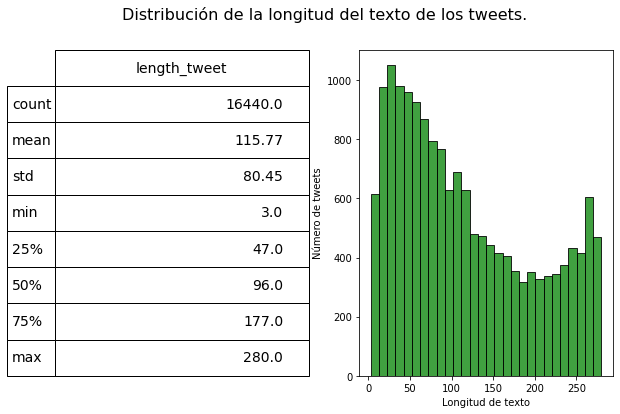

In [32]:
# Analizamos la variable de longitud del mensaje o tweet
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(122)
sns.histplot(df['length_tweet'], ax=ax1, color='green')
plt.ylabel("Número de tweets")
plt.xlabel("Longitud de texto")
describe = df['length_tweet'].describe().to_frame().round(2)
ax2 = fig.add_subplot(121)
ax2.axis('off')
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(14)
fig.suptitle('Distribución de la longitud del texto de los tweets.', fontsize=16)
plt.show()

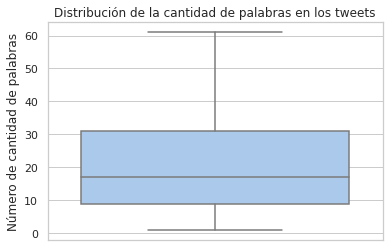

In [33]:
sns.set(style="whitegrid")
ax = sns.boxplot(y='number_words', data=df, palette='pastel')  
ax.set(xlabel='', ylabel='Número de cantidad de palabras')
plt.title("Distribución de la cantidad de palabras en los tweets")
plt.show()

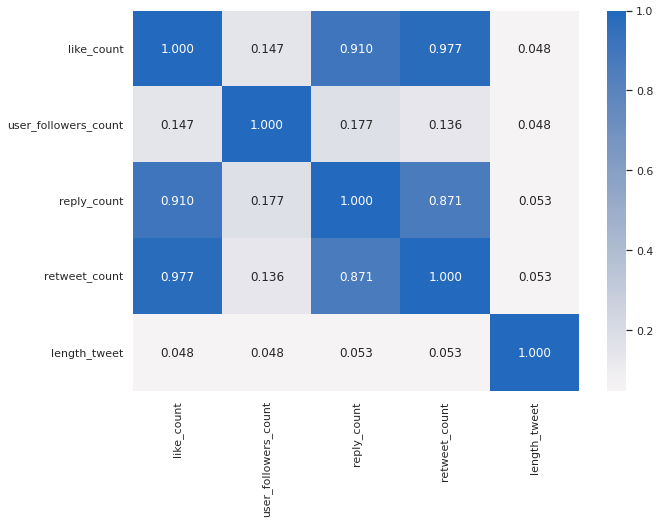

In [34]:
# Matriz de correlación entre variables numéricas
df_corr = df[['like_count', 'user_followers_count', 'reply_count', 'retweet_count', 'length_tweet']]
plt.figure(figsize = [10, 7])
sns.heatmap(df_corr.corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

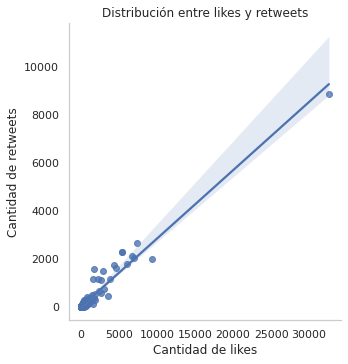

In [35]:
# Distribución de correlación y/o dispersión entre 'like_count' y 'retweet_count'
sns.lmplot(x="like_count", y="retweet_count", data=df, aspect=1)
plt.title("Distribución entre likes y retweets")
plt.xlabel("Cantidad de likes")
plt.ylabel("Cantidad de retweets")
plt.grid(False)
plt.show()

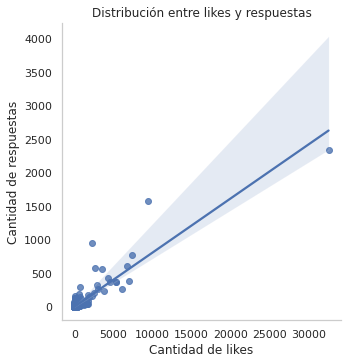

In [36]:
# Distribución de correlación y/o dispersión entre 'like_count' y 'reply_count'
sns.set(style=None)

sns.lmplot(x="like_count", y="reply_count", data=df, aspect=1)
plt.title("Distribución entre likes y respuestas")
plt.xlabel("Cantidad de likes")
plt.ylabel("Cantidad de respuestas")
plt.grid(False)
plt.show()

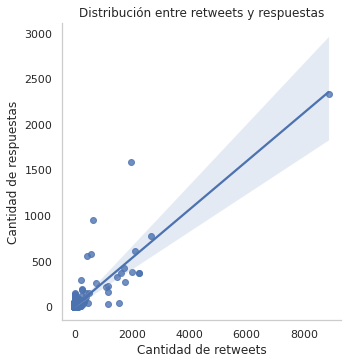

In [37]:
# Distribución de correlación y/o dispersión entre 'retweet_count' y 'reply_count'
sns.lmplot(x="retweet_count", y="reply_count", data=df, aspect=1)
plt.title("Distribución entre retweets y respuestas")
plt.xlabel("Cantidad de retweets")
plt.ylabel("Cantidad de respuestas")
plt.grid(False)
plt.show()

# **ANÁLISIS DE DATOS - DOMINIO**

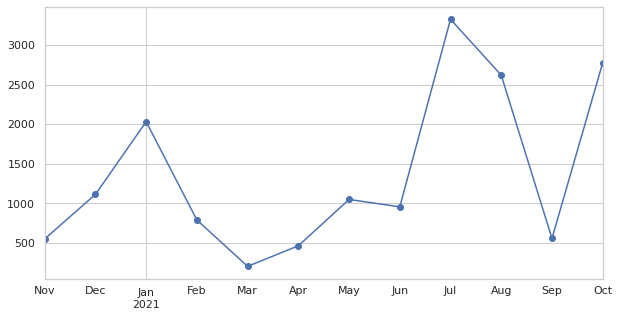

In [38]:
# Distribución de la cantidad de tweets durante el periodo de tiempo de un año (01/11/2020 - 31/10/2021)
df['date'] = pd.to_datetime(df['date'])
df['date'].value_counts().resample("m").sum().plot(style="-o", figsize=(10, 5));

Text(0, 0.5, 'Cantidad de tweets')

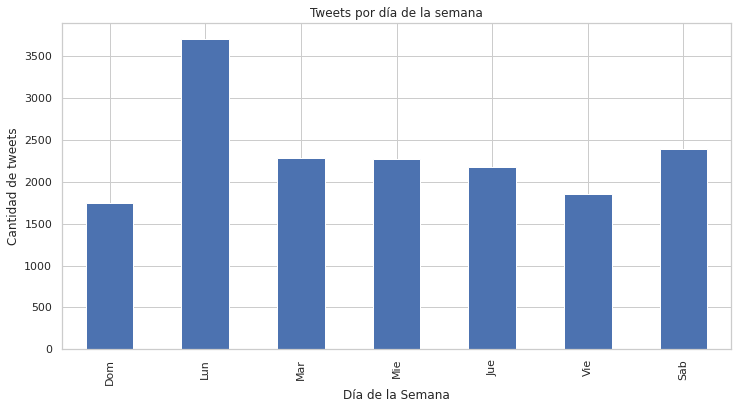

In [39]:
# Visualización de la cantidad de tweets por dia
ax = df['date'].dt.dayofweek.value_counts().sort_index().plot(kind='bar', figsize=(12,6), title='Tweets por día de la semana')
ax.set_xticklabels(['Dom','Lun','Mar','Mie','Jue','Vie','Sab'])
ax.set_xlabel("Día de la Semana")
ax.set_ylabel("Cantidad de tweets")

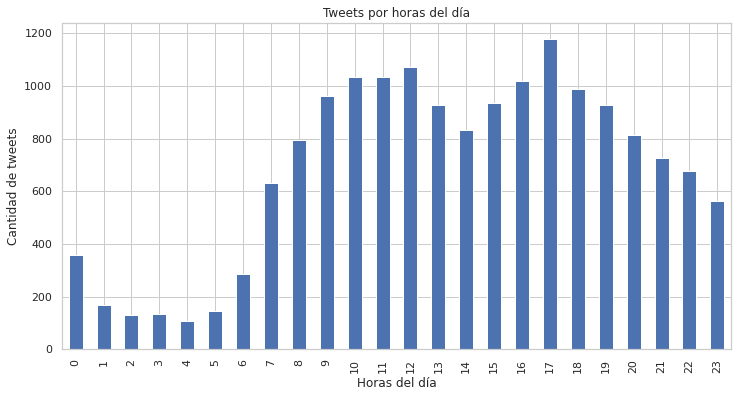

In [40]:
# Visualización de la cantidad de tweets repartidos durante las horas del día
df_hours = df[['date']]
df_hours['date_bo'] = df_hours['date'].dt.tz_convert('America/La_Paz')
df_hours['date_bo'].dt.hour.value_counts().sort_index().plot(kind='bar', 
                                                             figsize=(12,6), 
                                                             title='Tweets por horas del día', 
                                                             xlabel="Horas del día", 
                                                             ylabel="Cantidad de tweets")

Text(0.5, 1.0, 'Distribución de la cantidad de tweets por departamento en Bolivia')

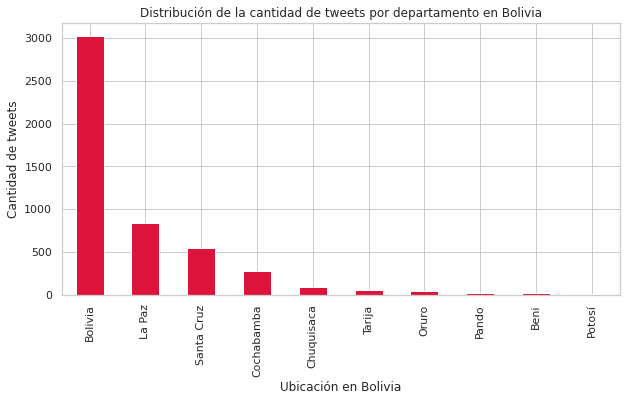

In [41]:
# Visualización de tweets por ubicación en Bolivia
plt.figure(figsize=(10,5)) 
df['location'].value_counts().plot(kind='bar', color = 'crimson')
plt.xlabel('Ubicación en Bolivia')
plt.ylabel('Cantidad de tweets')
plt.title('Distribución de la cantidad de tweets por departamento en Bolivia')

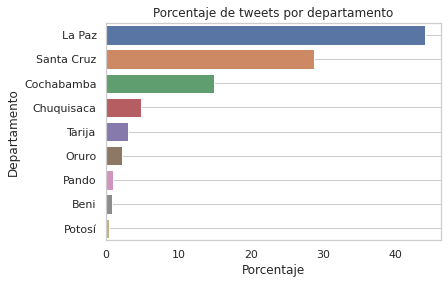

In [43]:
df_bol = df.copy()
df_bolivia = df_bol[~df_bol['location'].isna()]
df_bolivia = df_bolivia[~df_bolivia['location'].str.contains('Bolivia', na=False)]

deptos = df_bolivia['location'].unique()

dt = pd.DataFrame(deptos, columns=['place'])
dt['count'] = 0
dt['percent'] = 0.0

for i,d in enumerate(deptos):   
  dt['count'][i] = df_bolivia[df_bolivia['location'].str.contains(d, na=False)].shape[0]
  dt['percent'][i] = round(100 * dt['count'][i] / len(df_bolivia), 2)

dt = dt.sort_values('percent', ascending=False)

fig = sns.barplot(
    x=dt['percent'], 
    y=dt["place"], 
    orientation='horizontal')
plt.title("Porcentaje de tweets por departamento")
plt.xlabel("Porcentaje")
plt.ylabel("Departamento")
plt.grid()
plt.show()

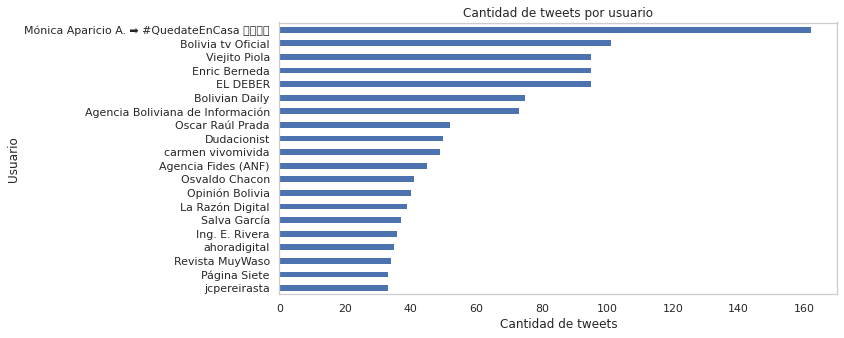

In [44]:
# Visualización de los usuarios con mayor cantidad de tweets
df['user_displayname'].value_counts().head(20).sort_values(ascending=True).plot(kind = 'barh', figsize = (10,5))       
plt.title("Cantidad de tweets por usuario")
plt.xlabel("Cantidad de tweets")
plt.ylabel("Usuario")
plt.grid(False)
plt.show()

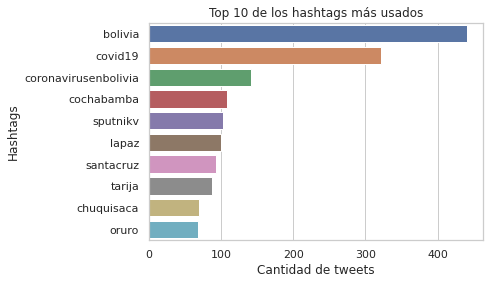

In [45]:
def split_hashtags(x): 
    return str(x).replace('[', '').replace(']', '').split(',')

tweets_df = df.copy()
tweets_df['hashtag'] = tweets_df['hashtags'].apply(lambda row : split_hashtags(row))
tweets_df = tweets_df.explode('hashtag')
tweets_df['hashtag'] = tweets_df['hashtag'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')

# tweets_df.loc[tweets_df['hashtag']=='', 'hashtag'] = 'NO HASHTAG'
tweets_df = tweets_df[~(tweets_df['hashtag'] == 'nan')]

ds = tweets_df['hashtag'].value_counts().reset_index()
ds.columns = ['hashtag', 'count']
ds = ds.sort_values(['count'],ascending=False)
fig = sns.barplot(
    x=ds.head(10)["count"], 
    y=ds.head(10)['hashtag'], 
    orientation='horizontal',
).set_title('Top 10 de los hashtags más usados')
plt.xlabel('Cantidad de tweets')
plt.ylabel('Hashtags')
plt.show()

In [47]:
# Exportar los datos para la obtención de la polaridad
import csv
df.to_csv('cleanedDataset2.csv', header=True, index=False)